### Created on 2025
### @author: S.W

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 시각화 설정
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🚀 RNN, LSTM, GRU 텍스트 분류 실습을 시작합니다!")
print("=" * 60)

🚀 RNN, LSTM, GRU 텍스트 분류 실습을 시작합니다!


#### 1. 데이터 준비 및 전처리


In [3]:
# 간단한 영화 리뷰 감성 분석 데이터셋 생성 (실제 상황에서는 IMDB 등 사용)
def create_sample_data():
    """
    초심자 이해를 위한 간단한 샘플 데이터 생성
    실제로는 datasets.load_dataset('imdb') 등을 사용하지만, 
    개념 이해를 위해 작은 데이터셋으로 시작
    """
    positive_reviews = [
        "This movie is absolutely amazing and wonderful",
        "I love this film it's fantastic and brilliant",
        "Great acting superb story highly recommend",
        "Excellent movie with outstanding performances",
        "Brilliant cinematography and amazing soundtrack",
        "Perfect film love every minute of it",
        "Outstanding story with excellent character development",
        "Amazing visual effects and great acting",
        "Superb direction and brilliant screenplay",
        "Fantastic movie highly recommended for everyone"
    ] * 50  # 500개 긍정 리뷰

    negative_reviews = [
        "This movie is terrible and boring waste of time",
        "Awful film with bad acting and poor story",
        "Horrible movie terrible performances very disappointing",
        "Bad film boring story terrible acting",
        "Worst movie ever seen very disappointing",
        "Terrible film awful story and bad direction",
        "Boring movie with poor acting and bad script",
        "Disappointing film terrible story and acting",
        "Awful movie waste of time and money",
        "Bad film poor story terrible performances"
    ] * 50  # 500개 부정 리뷰
    
    # 데이터프레임 생성
    data = []
    for review in positive_reviews:
        data.append({'text': review, 'label': 1})  # 1: 긍정
    for review in negative_reviews:
        data.append({'text': review, 'label': 0})  # 0: 부정
    
    return pd.DataFrame(data)

# 데이터 생성 및 확인
df = create_sample_data()
print(f"📊 데이터셋 크기: {len(df)}")
print(f"긍정 리뷰: {sum(df['label'] == 1)}개")
print(f"부정 리뷰: {sum(df['label'] == 0)}개")
print("\n샘플 데이터:")
print(df.head())

📊 데이터셋 크기: 1000
긍정 리뷰: 500개
부정 리뷰: 500개

샘플 데이터:
                                              text  label
0   This movie is absolutely amazing and wonderful      1
1    I love this film it's fantastic and brilliant      1
2       Great acting superb story highly recommend      1
3    Excellent movie with outstanding performances      1
4  Brilliant cinematography and amazing soundtrack      1


#### 2. 텍스트 전처리 및 토크나이징

In [4]:
class TextPreprocessor:
    """
    초심자를 위한 텍스트 전처리 클래스
    - 복잡한 전처리보다는 핵심 개념에 집중
    """
    def __init__(self):
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2
        
    def build_vocabulary(self, texts):
        """단어 사전 구축"""
        word_counts = Counter()
        
        for text in texts:
            # 간단한 토크나이징 (공백 기준)
            words = self.simple_tokenize(text)
            word_counts.update(words)
        
        # 빈도수 기준으로 상위 단어들만 사용 (vocab_size 제한)
        for word, count in word_counts.most_common(1000):  # 상위 1000개 단어만
            if word not in self.word_to_idx:
                self.word_to_idx[word] = self.vocab_size
                self.idx_to_word[self.vocab_size] = word
                self.vocab_size += 1
                
        print(f"📝 어휘집 크기: {self.vocab_size}")
        
    def simple_tokenize(self, text):
        """간단한 토크나이징"""
        # 소문자 변환 및 특수문자 제거
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        return text.split()
    
    def text_to_sequence(self, text, max_length=20):
        """텍스트를 숫자 시퀀스로 변환"""
        words = self.simple_tokenize(text)
        sequence = []
        
        for word in words[:max_length]:  # 최대 길이 제한
            sequence.append(self.word_to_idx.get(word, 1))  # <UNK> = 1
            
        # 패딩 추가
        while len(sequence) < max_length:
            sequence.append(0)  # <PAD> = 0
            
        return sequence

# 전처리기 초기화 및 어휘집 구축
preprocessor = TextPreprocessor()
preprocessor.build_vocabulary(df['text'].tolist())

# 데이터 변환
sequences = []
for text in df['text']:
    sequences.append(preprocessor.text_to_sequence(text))

df['sequence'] = sequences
print("\n🔄 텍스트 → 숫자 시퀀스 변환 완료")
print("예시:")
print(f"원본: {df.iloc[0]['text']}")
print(f"시퀀스: {df.iloc[0]['sequence']}")

📝 어휘집 크기: 56

🔄 텍스트 → 숫자 시퀀스 변환 완료
예시:
원본: This movie is absolutely amazing and wonderful
시퀀스: [10, 3, 19, 31, 11, 2, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### 3. 데이터셋 클래스 정의

In [5]:
class TextDataset(Dataset):
    """
    PyTorch 데이터셋 클래스
    초심자가 이해하기 쉽도록 간단하게 구현
    """
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# 데이터 분할
X = df['sequence'].tolist()
y = df['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 데이터셋 생성
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

# 데이터로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"🔨 훈련 데이터: {len(train_dataset)}개")
print(f"🔨 테스트 데이터: {len(test_dataset)}개")

🔨 훈련 데이터: 800개
🔨 테스트 데이터: 200개


#### 4. 모델 정의: RNN, LSTM, GRU

In [6]:
class SimpleRNN(nn.Module):
    """
    기본 RNN 모델
    초심자 이해를 위해 구조를 명확하게 표현
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleRNN, self).__init__()
        
        # 임베딩 레이어: 단어 인덱스 → 벡터
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # RNN 레이어
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
        # 분류를 위한 완전연결 레이어
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # 드롭아웃 (과적합 방지)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # x: (batch_size, sequence_length)
        
        # 1. 임베딩
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # 2. RNN 통과
        rnn_out, hidden = self.rnn(embedded)  # rnn_out: (batch_size, seq_len, hidden_dim)
        
        # 3. 마지막 타임스텝의 출력 사용
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # 4. 드롭아웃 적용
        last_output = self.dropout(last_output)
        
        # 5. 분류
        output = self.fc(last_output)  # (batch_size, output_dim)
        
        return output

In [7]:
class SimpleLSTM(nn.Module):
    """
    LSTM 모델
    RNN의 기울기 소실 문제를 해결한 버전
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM 레이어 (RNN 대신 LSTM 사용)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        # LSTM은 hidden state와 cell state 모두 반환
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # 마지막 타임스텝 출력 사용
        last_output = lstm_out[:, -1, :]
        last_output = self.dropout(last_output)
        
        output = self.fc(last_output)
        return output

In [8]:
class SimpleGRU(nn.Module):
    """
    GRU 모델
    LSTM보다 간단하면서도 성능이 비슷한 모델
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleGRU, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # GRU 레이어
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        # GRU는 hidden state만 반환 (cell state 없음)
        gru_out, hidden = self.gru(embedded)
        
        last_output = gru_out[:, -1, :]
        last_output = self.dropout(last_output)
        
        output = self.fc(last_output)
        return output

In [9]:
# 모델 하이퍼파라미터
vocab_size = preprocessor.vocab_size
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # 이진 분류 (긍정/부정)
num_layers = 2

# 모델 인스턴스 생성
rnn_model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
lstm_model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
gru_model = SimpleGRU(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)

print("🤖 모델 생성 완료:")
print(f"   - RNN 파라미터 수: {sum(p.numel() for p in rnn_model.parameters()):,}")
print(f"   - LSTM 파라미터 수: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"   - GRU 파라미터 수: {sum(p.numel() for p in gru_model.parameters()):,}")

🤖 모델 생성 완료:
   - RNN 파라미터 수: 68,322
   - LSTM 파라미터 수: 255,714
   - GRU 파라미터 수: 193,250


#### 5. 훈련 및 평가 함수

In [10]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    """
    모델 훈련 함수
    초심자가 훈련 과정을 이해할 수 있도록 상세한 로그 포함
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print(f"🚀 훈련 시작 (장치: {device})")
    print("=" * 50)
    
    for epoch in range(epochs):
        # 훈련 모드
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        # 훈련 배치 처리
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
        
        train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # 평가 모드
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                test_correct += pred.eq(target).sum().item()
                test_total += target.size(0)
        
        test_acc = 100. * test_correct / test_total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1:2d}/{epochs}: '
              f'Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Test Acc: {test_acc:.2f}%')
    
    return train_losses, train_accuracies, test_accuracies

def evaluate_model(model, test_loader):
    """모델 상세 평가"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, 
                                 target_names=['부정', '긍정'])
    
    return accuracy, report, all_targets, all_preds

#### 6. 모델 훈련 및 비교

In [11]:
print("\n🔥 모델별 훈련 시작!")
print("=" * 60)

# 각 모델 훈련
models = {
    'RNN': rnn_model,
    'LSTM': lstm_model, 
    'GRU': gru_model
}

results = {}

for name, model in models.items():
    print(f"\n📊 {name} 모델 훈련 중...")
    
    train_losses, train_accs, test_accs = train_model(
        model, train_loader, test_loader, epochs=15, lr=0.001
    )
    
    # 평가
    accuracy, report, targets, preds = evaluate_model(model, test_loader)
    
    results[name] = {
        'model': model,
        'train_losses': train_losses,
        'train_accuracies': train_accs,
        'test_accuracies': test_accs,
        'final_accuracy': accuracy,
        'report': report,
        'targets': targets,
        'predictions': preds
    }
    
    print(f"✅ {name} 최종 정확도: {accuracy:.4f}")


🔥 모델별 훈련 시작!

📊 RNN 모델 훈련 중...
🚀 훈련 시작 (장치: cuda)
Epoch  1/15: Loss: 0.4362, Train Acc: 76.00%, Test Acc: 100.00%
Epoch  2/15: Loss: 0.0009, Train Acc: 100.00%, Test Acc: 100.00%
Epoch  3/15: Loss: 0.0002, Train Acc: 100.00%, Test Acc: 100.00%
Epoch  4/15: Loss: 0.0002, Train Acc: 100.00%, Test Acc: 100.00%
Epoch  5/15: Loss: 0.0002, Train Acc: 100.00%, Test Acc: 100.00%
Epoch  6/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch  7/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch  8/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch  9/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch 10/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch 11/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch 12/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch 13/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch 14/15: Loss: 0.0001, Train Acc: 100.00%, Test Acc: 100.00%
Epoch 15/15: Loss: 0.0001, Train Acc: 10

#### 7. 결과 시각화 및 비교

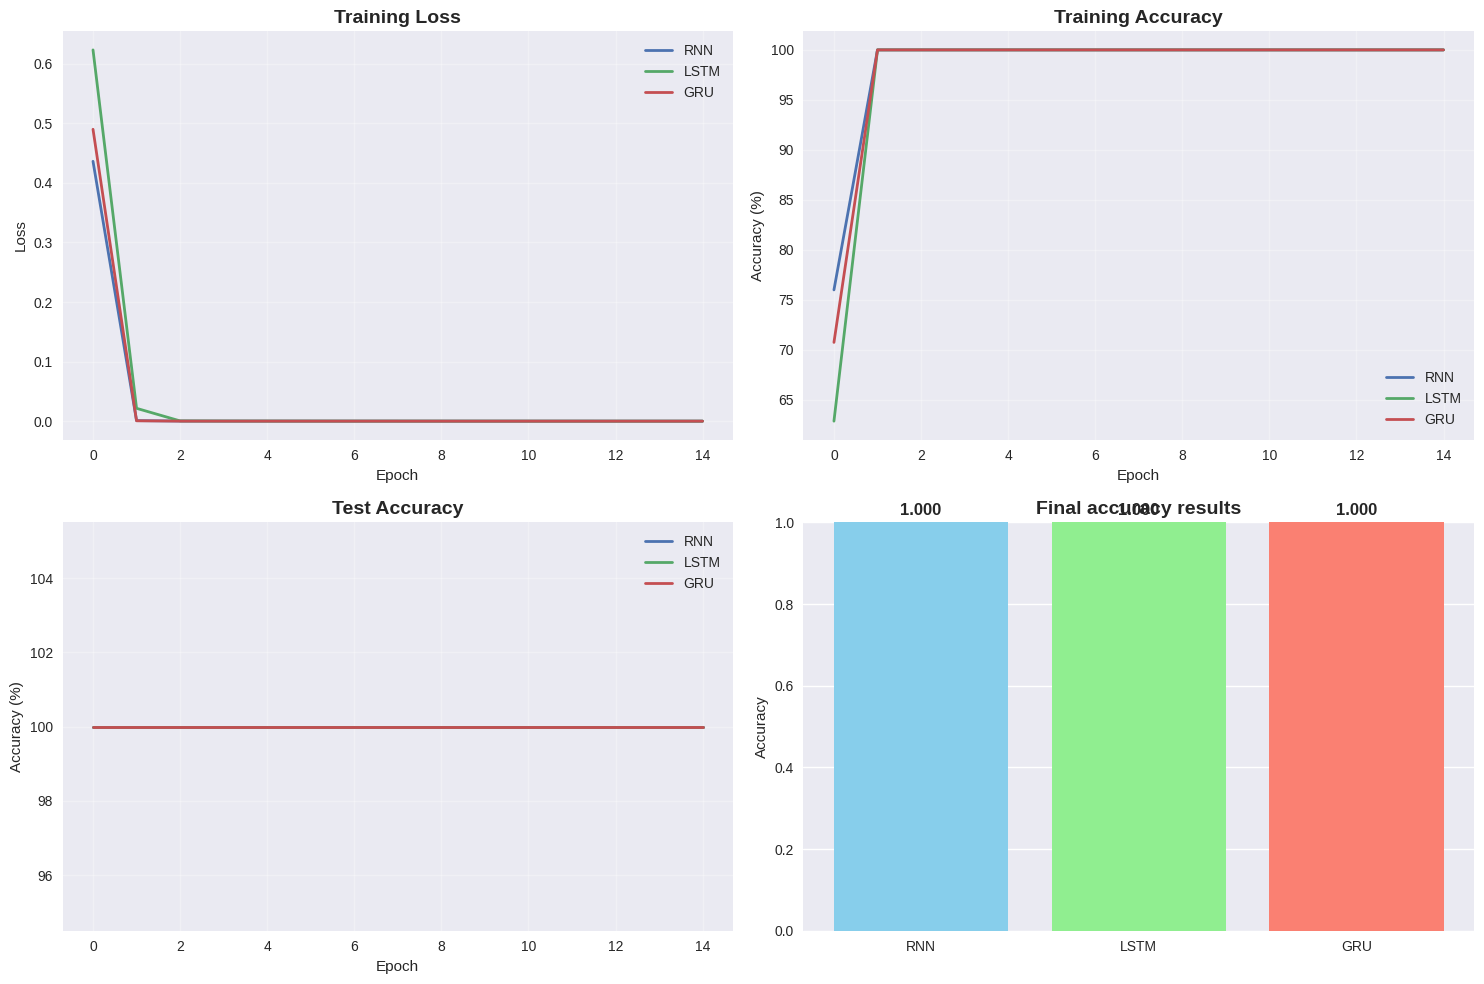

In [12]:
# 훈련 과정 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 손실 곡선
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
for name, result in results.items():
    axes[0, 0].plot(result['train_losses'], label=name, linewidth=2)
axes[0, 0].legend()
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# 훈련 정확도
axes[0, 1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
for name, result in results.items():
    axes[0, 1].plot(result['train_accuracies'], label=name, linewidth=2)
axes[0, 1].legend()
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].grid(True, alpha=0.3)

# 테스트 정확도
axes[1, 0].set_title('Test Accuracy', fontsize=14, fontweight='bold')
for name, result in results.items():
    axes[1, 0].plot(result['test_accuracies'], label=name, linewidth=2)
axes[1, 0].legend()
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].grid(True, alpha=0.3)

# 최종 성능 비교
model_names = list(results.keys())
final_accuracies = [results[name]['final_accuracy'] for name in model_names]

axes[1, 1].set_title('Final accuracy results', fontsize=14, fontweight='bold')
bars = axes[1, 1].bar(model_names, final_accuracies, 
                      color=['skyblue', 'lightgreen', 'salmon'])
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)

# 막대 위에 정확도 값 표시
for bar, acc in zip(bars, final_accuracies):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

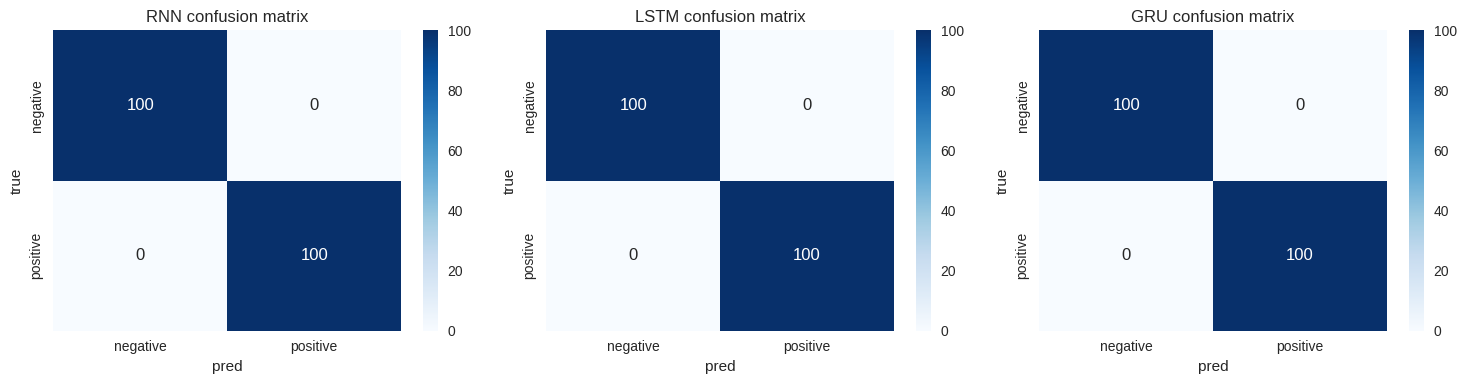

In [13]:
# 혼동 행렬 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(result['targets'], result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['negative', 'positive'], 
                yticklabels=['negative', 'positive'], 
                ax=axes[idx])
    axes[idx].set_title(f'{name} confusion matrix')
    axes[idx].set_xlabel('pred')
    axes[idx].set_ylabel('true')

plt.tight_layout()
plt.show()

In [14]:
# ==================================================================================
# 8. 상세 분석 및 해석
# ==================================================================================

print("\n📈 모델 성능 상세 분석")
print("=" * 60)

best_model_name = max(results.keys(), key=lambda x: results[x]['final_accuracy'])
print(f"🏆 최고 성능 모델: {best_model_name}")
print(f"   정확도: {results[best_model_name]['final_accuracy']:.4f}")

print(f"\n📊 각 모델별 분류 리포트:")
for name, result in results.items():
    print(f"\n{name} 모델:")
    print(result['report'])


📈 모델 성능 상세 분석
🏆 최고 성능 모델: RNN
   정확도: 1.0000

📊 각 모델별 분류 리포트:

RNN 모델:
              precision    recall  f1-score   support

          부정       1.00      1.00      1.00       100
          긍정       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


LSTM 모델:
              precision    recall  f1-score   support

          부정       1.00      1.00      1.00       100
          긍정       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


GRU 모델:
              precision    recall  f1-score   support

          부정       1.00      1.00      1.00       100
          긍정       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00    

In [15]:
# ==================================================================================
# 9. 실제 예측 테스트
# ==================================================================================

def predict_sentiment(model, text, preprocessor):
    """새로운 텍스트의 감성 예측"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # 전처리
    sequence = preprocessor.text_to_sequence(text)
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    with torch.no_grad():
        output = model(sequence_tensor)
        probabilities = F.softmax(output, dim=1)
        prediction = output.argmax(dim=1).item()
        confidence = probabilities[0][prediction].item()
    
    sentiment = "긍정" if prediction == 1 else "부정"
    return sentiment, confidence

# 테스트 문장들
test_sentences = [
    "This movie is absolutely fantastic!",
    "Terrible film, waste of my time",
    "Great story and amazing acting",
    "Boring and disappointing movie"
]

print(f"\n🔮 실제 예측 테스트 ({best_model_name} 모델 사용)")
print("=" * 60)

best_model = results[best_model_name]['model']
for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(best_model, sentence, preprocessor)
    print(f"문장: '{sentence}'")
    print(f"예측: {sentiment} (신뢰도: {confidence:.4f})")
    print("-" * 40)


🔮 실제 예측 테스트 (RNN 모델 사용)
문장: 'This movie is absolutely fantastic!'
예측: 긍정 (신뢰도: 1.0000)
----------------------------------------
문장: 'Terrible film, waste of my time'
예측: 부정 (신뢰도: 0.9999)
----------------------------------------
문장: 'Great story and amazing acting'
예측: 긍정 (신뢰도: 1.0000)
----------------------------------------
문장: 'Boring and disappointing movie'
예측: 부정 (신뢰도: 0.9999)
----------------------------------------


### 초심자를 위한 핵심 개념 정리
RNN (Recurrent Neural Network):
- 순서가 있는 데이터(시퀀스)를 처리하는 신경망
- 이전 시점의 정보를 기억하여 현재 예측에 활용
- 문제점: 긴 시퀀스에서 기울기 소실 문제 발생

LSTM (Long Short-Term Memory):
- RNN의 기울기 소실 문제를 해결한 개선 버전
- Cell State와 Hidden State 두 가지 상태 유지
- Forget Gate, Input Gate, Output Gate로 정보 제어
- 장기 의존성 문제 해결에 효과적

GRU (Gated Recurrent Unit):
- LSTM보다 간단한 구조로 비슷한 성능 달성
- Reset Gate와 Update Gate 두 개의 게이트만 사용
- 파라미터 수가 적어 훈련 속도가 빠름
- 실무에서 LSTM과 함께 널리 사용